In [21]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [22]:
import datetime
from sklearn import preprocessing

In [23]:
features = pd.read_csv('./temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [24]:
features.shape

(348, 9)

In [25]:
years = features['year']
months = features['month']
days = features['day']

dates = [str(int(years)) + '-' + str(int(months)) + '-' + str(int(days)) for years, months, days in zip(years, months, days)]
dates = [datetime.datetime.strptime(dates, '%Y-%m-%d') for dates in dates]
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

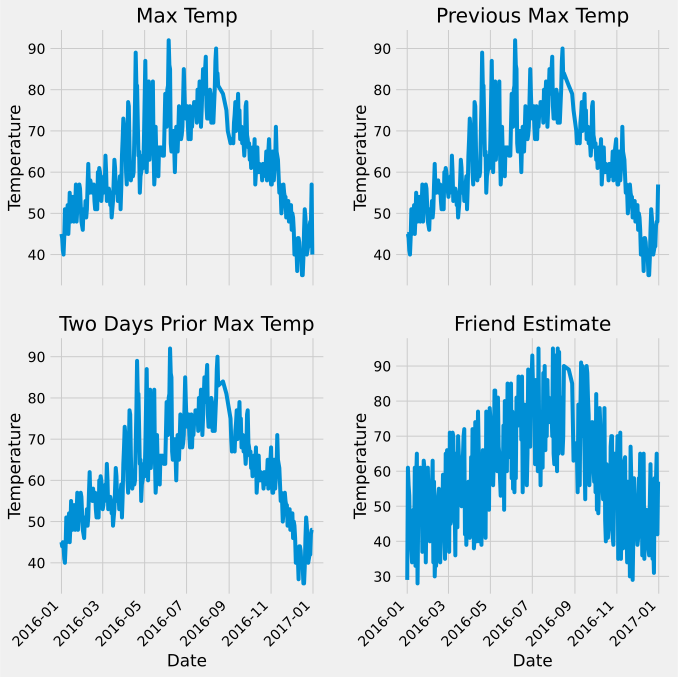

In [26]:
plt.style.use('fivethirtyeight')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.autofmt_xdate(rotation=45)

ax1.plot(dates, features['actual'])
ax1.set_xlabel('')
ax1.set_ylabel('Temperature')
ax1.set_title('Max Temp')

ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Max Temp')

ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature')
ax3.set_title('Two Days Prior Max Temp')

ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature')
ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [27]:
features = pd.get_dummies(features) # One-hot encoding
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [28]:
labels = np.array(features['actual'])
features = features.drop('actual', axis=1)
feature_list = list(features.columns)
features = np.array(features)
features.shape

(348, 14)

In [29]:
input_features = preprocessing.StandardScaler().fit_transform(features)

In [30]:
x_train = torch.tensor(input_features, dtype=torch.float32)
y_train = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
x_train.shape,  y_train.shape

(torch.Size([348, 14]), torch.Size([348, 1]))

In [31]:
weights = torch.randn((x_train.shape[1], 128), dtype=torch.float32, requires_grad=True)
bias = torch.randn(128, dtype=torch.float32, requires_grad=True)
weights2 = torch.randn((128, 1), dtype=torch.float32, requires_grad=True)
bias2 = torch.randn(1, dtype=torch.float32, requires_grad=True)

learning_rate = 0.001
losses = []

for i in range(1000):
    hidden = x_train.mm(weights) + bias
    hidden = torch.relu(hidden)
    predictions = hidden.mm(weights2) + bias2
    loss = torch.mean((predictions - y_train) ** 2)
    losses.append(loss.item())

    if i % 100 == 0:
        print(f'Loss at iteration {i} is {loss.item()}')

    loss.backward()

    weights.data.add_(-learning_rate * weights.grad)
    bias.data.add_(-learning_rate * bias.grad)
    weights2.data.add_(-learning_rate * weights2.grad)
    bias2.data.add_(-learning_rate * bias2.grad)

    weights.grad.zero_()
    bias.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

Loss at iteration 0 is 7554.63525390625
Loss at iteration 100 is 26.628971099853516
Loss at iteration 200 is 19.82648277282715
Loss at iteration 300 is 17.22040557861328
Loss at iteration 400 is 15.605874061584473
Loss at iteration 500 is 14.453353881835938
Loss at iteration 600 is 13.569268226623535
Loss at iteration 700 is 12.797958374023438
Loss at iteration 800 is 12.120668411254883
Loss at iteration 900 is 11.521587371826172


In [32]:
input_size = x_train.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)

cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [33]:
losses = []
for i in range(1000):
    batch_loss = []
    for start in range(0, len(x_train), batch_size):
        end = start + batch_size if start + batch_size < len(x_train) else len(x_train)
        xx = torch.tensor(x_train[start:end], dtype= torch.float, requires_grad=True)
        yy = torch.tensor(y_train[start:end], dtype= torch.float, requires_grad=True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    losses.append(np.mean(batch_loss))
    if i % 100 == 0:
        print(f'Loss at iteration {i} is {loss.item()}')

/var/folders/6s/jttrjjc92qj8wflfcb45sxlw0000gn/T/ipykernel_38384/2895853467.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(x_train[start:end], dtype= torch.float, requires_grad=True)
/var/folders/6s/jttrjjc92qj8wflfcb45sxlw0000gn/T/ipykernel_38384/2895853467.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy = torch.tensor(y_train[start:end], dtype= torch.float, requires_grad=True)


Loss at iteration 0 is 2034.4136962890625
Loss at iteration 100 is 25.808053970336914
Loss at iteration 200 is 26.210195541381836
Loss at iteration 300 is 25.615028381347656
Loss at iteration 400 is 23.8386173248291
Loss at iteration 500 is 22.264833450317383
Loss at iteration 600 is 20.90726089477539
Loss at iteration 700 is 19.620262145996094
Loss at iteration 800 is 18.323972702026367
Loss at iteration 900 is 17.06893539428711


In [34]:
x = torch.tensor(x_train, dtype=torch.float)
predict = my_nn(x).detach().numpy()

/var/folders/6s/jttrjjc92qj8wflfcb45sxlw0000gn/T/ipykernel_38384/3036380884.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_train, dtype=torch.float)


In [35]:
dates = [str(int(years)) + '-' + str(int(months)) + '-' + str(int(days)) for years, months, days in zip(years, months, days)]
dates = [datetime.datetime.strptime(dates, '%Y-%m-%d') for dates in dates]

true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data={'date': test_dates, 'prediction': predict.reshape(-1)})

ValueError: rotation must be 'vertical', 'horizontal' or a number, not 60

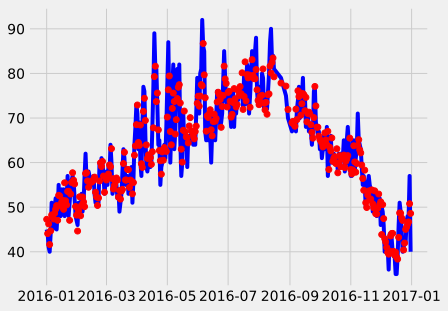

In [36]:
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation='60')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Max Temperature (F)')
plt.title('Actual and Predicted Values')